## Scraping for Bursa stock summary
* Table is generated from the screener
* Go to inspect and under Network, find the request that the website requested for the table data
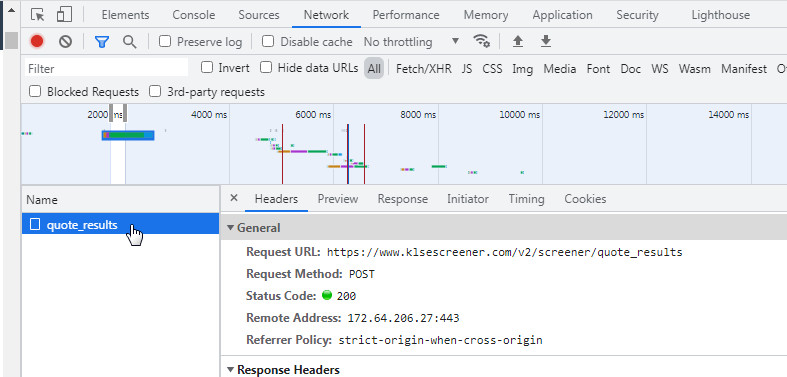

* Get the html of the page using cloudscaper and save it as a soup object
* Get each row as a list and save it into a master list
* Convert the master list into Pandas DataFrame
* 

In [1]:
!pip install cloudscraper

     |████████████████████████████████| 96 kB 2.7 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 


In [2]:
import cloudscraper
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from statistics import mean,median

In [3]:
def get_page(url):
    scraper=cloudscraper.create_scraper(browser='chrome')
    html=scraper.get(url)
    soup=BeautifulSoup(html.text)
    return soup

In [4]:
def get_table(soup):
    # find all the rows of the table
    rows=soup.findAll('tr',{'class':'list'})
    results=[]
    for row in rows:
        # strings
        full_name=row.find('td')['title']
        name=row.find('td').text.split('\n')[0]
        code=row.find('td',{'title':'Code'}).text
        sector=row.find('td',{'title':'Category'}).text.split(',')[0]
        market=row.find('td',{'title':'Category'}).text.split(',')[-1]
        
        # floats; first get the string and convert to float
        price=row.find('td',{'title':re.compile('Price')}).text
        price=format(float(price),'.3f')
        price=float(price)
        

        if row.find('td',{'title':'52week'}).text=='-':
            week52_low=np.nan
            week52_high=np.nan
        else:
            week52_low=row.find('td',{'title':'52week'}).text.split('-')[0]
            week52_low=format(float(week52_low),'.3f')
            week52_low=float(week52_low)

            week52_high=row.find('td',{'title':'52week'}).text.split('-')[1]
            week52_high=format(float(week52_high),'.3f')
            week52_high=float(week52_high)

        volume=row.find('td',{'title':'Volume'}).text
        volume=int(volume.replace(',',''))

        eps=row.find('td',{'title':'EPS'}).text
        if len(eps)==0:
            eps=np.nan
        else:
            eps=format(float(eps),'.2f')
            eps=float(eps)

        dps=row.find('td',{'title':'DPS'}).text
        dps=format(float(dps),'.2f')
        dps=float(dps)

        nta=row.find('td',{'title':'NTA'}).text
        if len(nta)==0:
            nta=np.nan
        else:
            nta=format(float(nta),'.3f')
            nta=float(nta)

        pe=row.find('td',{'title':'PE'}).text
        if len(pe)==0:
            pe=np.nan
        else:
            pe=format(float(pe.replace(',','')),'.2f')
            pe=float(pe)

        psr=get_psr(code)


        peg=get_peg(pe,code)
        peg=format(float(peg),'.2f')
        peg=float(peg)

        dy=row.find('td',{'title':'DY'}).text
        dy=format(float(dy),'.2f')
        dy=float(dy)

        dgr, dgr_median=get_div_growth(code)
        dgr=float(format(dgr,'.2f'))
        dgr_median=float(format(dgr_median,'.2f'))

        roe=row.find('td',{'title':'ROE'}).text
        roe=float(format(float(roe.replace(',','')),'.2f'))

        ptbv=row.find('td',{'title':'PTBV'}).text
        if len(ptbv)==0:
            ptbv=np.nan
        else:
            ptbv=format(float(ptbv),'.2f')
            ptbv=float(ptbv)

        mcap=row.find('td',{'title':'Market Capital'}).text
        mcap=format(float(mcap),'.2f')
        mcap=float(mcap)

        link=row.find('a')['href']
        link='https://www.klsescreener.com'+link
        result=[full_name,name,code,sector,market,price,week52_low,week52_high,volume,eps,dps,nta,pe,psr,peg,dy,dgr,dgr_median,roe,ptbv,mcap,link]
        results.append(result)
        print(code)        
    headers=columns=['Company Name','Name','Code','Sector','Market','Price','52week low','52week high','Volume','EPS','DPS','NTA','PE','PSR','PEG','DY','DGR','DGR_med','ROE','PTBV','MCap','link']
    df=pd.DataFrame(results,columns=headers)
    return df

In [5]:
def get_sectors(df):
    sectors_name=['bond_islamic', 'closed_end_fund', 'construction', 'CPS', 'energy', 'etf_bond', 'etf_commodity', 'etf_equity', 'financial_services', 'health_care', 'IPS', 'plantation', 'property', 'REITS', 'SPAC', 'tech', 'TM', 'TL', 'utilities']
    sectors=list(set(df['Sector']))[1:]
    sectors.sort(key=str.lower)
    for sector, name in zip(sectors,sectors_name):
        globals()[name]=df[df['Sector']==sector]

In [6]:
def get_div_growth(code):
    stock_url='https://www.klsescreener.com/v2/stocks/dividend_chart/{}?theme=light'.format(code)
    stock_soup=get_page(stock_url).text
    result=re.findall('\[\'FY.*\]',stock_soup)
    div_growth=[]
    mean_growth=np.nan
    median_growth=np.nan
    for i in range(len(result)):
        try:
            div0=float(result[i].replace('\'','').replace("[","").replace("]","").split(",")[2])
            div1=float(result[i+1].replace('\'','').replace("[","").replace("]","").split(",")[2])
            try:
                growth=(div1-div0)/div0*100
                div_growth.append(growth)
            except ZeroDivisionError:
                pass
        except IndexError:
            pass
    try:
        mean_growth=mean(div_growth)
    except:
        mean_growth=np.nan
    try:
        median_growth=median(div_growth)
    except:
        median_growth=np.nan
    return mean_growth, median_growth

In [42]:
def get_peg(pe,code):
    url='https://www.klsescreener.com/v2/stocks/view/{}'.format(code)
    soup=get_page(url)
    table=soup.find('div',{'class':'financial_reports_content table-responsive tab-pane'}).findAll('tr')
    eps_growth=[]
    # taking into account 5 years growth of eps by default
    for i in range(1,5):
        try:
            eps_0=float(table[i].findAll('td')[3].text)
            eps_1=float(table[i+1].findAll('td')[3].text)
            growth=(eps_0-eps_1)/eps_1*100
            eps_growth.append(growth)
        except:
            pass
    try:
        eps_growth_avg=mean(eps_growth)
        peg=pe/eps_growth_avg
    except:
        peg=np.nan
    return peg

In [50]:
def get_psr(code):
    url='https://www.klsescreener.com/v2/stocks/view/{}'.format(code)
    soup=get_page(url)
    try:
        psr=soup.find('td',{'title':'Price to Sales ratio'}).find_next('td').text
        psr=format(float(psr),'.2f')
        psr=float(psr)
    except:
        psr=np.nan
    return psr

In [ ]:
# create a full table
url="https://www.klsescreener.com/v2/screener/quote_results"
df=get_table(get_page(url))

In [57]:
# create a backup for df
df_backup=df.copy()

In [89]:
# clean up the duplicated values
df['Sector'].replace(['Plantations','Telecomunications & Media'],['Plantation','Telecommunication & Media'],inplace=True)

# replace empty string values as NaN
df.Sector.replace('^\s*$',np.nan,regex=True, inplace=True)
df.Market.replace('^\s*$',np.nan,regex=True, inplace=True)

In [90]:
# check and confirm there are no duplicate values for sectors
sectors=list(set(df['Sector']))[1:]
sectors.sort(key=str.lower)
print(sectors)

['Bond Islamic', 'Closed-End Fund', 'Construction', 'Consumer Products & Services', 'Energy', 'ETF-Bond', 'ETF-Commodity', 'ETF-Equity', 'Financial Services', 'Health Care', 'Industrial Products & Services', 'Plantation', 'Property', 'Real Estate Investment Trusts', 'SPAC', 'Technology', 'Telecommunication & Media', 'Telecommunications & Media', 'Transportation & Logistics', 'Utilities']


In [13]:
# create dataframe for each individual sectors
get_sectors(df)

#### **List of Sectors and their respective dataframe names:**
* Bond Islamic: bond_islamic
* Closed-End Fund: closed_end_fund
* Construction: construction
* Consumer Products & Services: CPS
* Energy: energy
* ETF-Bond: etf_bond
* ETF-Commodity: etf_commodity
* ETF-Equity: etf_equity
* Financial Servies: financial_services
* Health Care: health_care
* Industrial Products & Services: IPS
* Plantation: plantation
* Property: property
* Real Estate Investment Trusts: REITS
* SPAC: SPAC
* Technology: tech
* Telecommunication & Media: TM
* Transportation & Logistics: TL
* Utilities: utilities



In [91]:
# calculate DPR value and insert in loc 11
df.insert(11,'DPR',df['DPS']/df['EPS']*100)

# round the DPR value to 2 decimal points
df['DPR'] = df['DPR'].round(2)

In [58]:
# export df to csv
df.to_csv('all_stocks.csv')

In [69]:
# number of shares under each sector
df.Sector.value_counts()

Industrial Products & Services    270
Consumer Products & Services      200
Technology                        104
Property                           99
Construction                       62
Plantation                         41
Transportation & Logistics         35
Energy                             34
Financial Services                 34
Telecommunications & Media         30
Health Care                        24
Real Estate Investment Trusts      18
Utilities                          13
ETF-Equity                         12
                                    8
Bond Islamic                        3
Closed-End Fund                     1
ETF-Bond                            1
Plantations                         1
ETF-Commodity                       1
SPAC                                1
Telecomunications & Media           1
Name: Sector, dtype: int64

In [56]:
# shape of the dataframe
df.shape

(993, 22)

In [94]:
# number of nulll values and data type for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company Name  993 non-null    object 
 1   Name          993 non-null    object 
 2   Code          993 non-null    object 
 3   Sector        985 non-null    object 
 4   Market        985 non-null    object 
 5   Price         993 non-null    float64
 6   52week low    991 non-null    float64
 7   52week high   991 non-null    float64
 8   Volume        993 non-null    int64  
 9   EPS           983 non-null    float64
 10  DPS           993 non-null    float64
 11  DPR           983 non-null    float64
 12  NTA           983 non-null    float64
 13  PE            983 non-null    float64
 14  PSR           957 non-null    float64
 15  PEG           962 non-null    float64
 16  DY            993 non-null    float64
 17  DGR           714 non-null    float64
 18  DGR_med       714 non-null    

In [93]:
df.sort_values(['DGR_med'],ascending=False).head(25)

,Company Name,Name,Code,Sector,Market,Price,52week low,52week high,Volume,EPS,DPS,DPR,NTA,PE,PSR,PEG,DY,DGR,DGR_med,ROE,PTBV,MCap,link
953,COMINTEL CORPORATION BHD,COMCORP,7195,Industrial Products & Services,Main Market,0.090,0.025,0.205,0,-1.89,0.00,-0.00,0.060,-4.76,1.05,0.04,0.00,1065.00,1065.00,-31.48,1.50,12.60,https://www.klsescreener.com/v2/stocks/view/71...
857,KOMARKCORP BERHAD,KOMARK,7017,Industrial Products & Services,Main Market,0.145,0.080,0.895,113324,-2.38,0.00,-0.00,0.230,-6.10,1.66,0.15,0.00,900.00,900.00,-10.33,0.63,83.72,https://www.klsescreener.com/v2/stocks/view/70...
450,TRADEPLUS MSCI ASIA EX JAPAN REITS TRACKER,AXJ-REITSETF,0837EA,ETF-Equity,ETF,0.990,0.955,1.110,10,5.75,3.50,60.87,1.029,17.21,13.37,3.04,3.54,600.00,600.00,4.20,0.96,2.82,https://www.klsescreener.com/v2/stocks/view/08...
65,TASHIN HOLDINGS BERHAD,TASHIN,0211,Industrial Products & Services,Ace Market,0.535,0.330,0.870,1834,15.22,2.00,13.14,0.690,3.51,0.53,0.01,3.74,300.00,300.00,22.06,0.78,186.71,https://www.klsescreener.com/v2/stocks/view/02...
942,CONCRETE ENGINEERING PRODUCTS BERHAD,CEPCO,8435,Industrial Products & Services,Main Market,0.870,0.535,1.230,50,-22.56,0.00,-0.00,0.820,-3.86,0.77,-0.19,0.00,266.67,266.67,-27.51,1.06,64.92,https://www.klsescreener.com/v2/stocks/view/84...
607,ATTA GLOBAL GROUP BERHAD,ATTA,7099,Industrial Products & Services,Main Market,0.405,0.385,0.700,0,0.81,0.00,0.00,1.680,50.30,1.06,-0.08,0.00,214.58,214.58,0.48,0.24,90.08,https://www.klsescreener.com/v2/stocks/view/70...
372,CARIMIN PETROLEUM BERHAD,CARIMIN,5257,Energy,Main Market,0.785,0.473,0.820,13877,4.43,6.00,135.44,0.769,17.72,1.09,-0.21,7.64,180.00,200.00,5.76,1.02,183.59,https://www.klsescreener.com/v2/stocks/view/52...
931,GREEN PACKET BERHAD,GPACKET,0082,Telecommunications & Media,Main Market,0.085,0.070,0.465,12635,-4.98,0.00,-0.00,0.210,-1.71,0.23,-0.03,0.00,150.00,150.00,-23.69,0.40,119.27,https://www.klsescreener.com/v2/stocks/view/00...
79,INNOPRISE PLANTATIONS BERHAD,INNO,6262,Plantation,Main Market,1.320,0.901,1.400,1723,13.29,16.00,120.39,0.670,9.93,3.24,0.23,12.12,108.23,146.15,19.84,1.97,632.09,https://www.klsescreener.com/v2/stocks/view/62...
970,MATRIX PARKING SOLUTION HOLDINGS BERHAD,MPSOL,03019,Consumer Products & Services,Leap Market,0.180,0.110,0.180,0,-1.63,0.00,-0.00,0.030,-11.02,2.29,-0.05,0.00,142.86,142.86,-55.38,6.10,40.11,https://www.klsescreener.com/v2/stocks/view/03...


In [130]:
# filter out all the stocks with no dividend
df_div=df[df['DY']!=0]

In [145]:
# remove DGR which are NaN value; this means the company only pay out dividend once
df_div.dropna(subset=['DGR'],inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
df_div.shape

(432, 20)

In [147]:
df_div.sort_values(['DY','DGR_med'],ascending=False)

,Company Name,Name,Code,Sector,Market,Price,52week low,52week high,Volume,EPS,DPS,NTA,PE,DY,DGR,DGR_med,ROE,PTBV,MCap,link
540,PELIKAN INTERNATIONAL CORPORATION BERHAD,PELIKAN,5231,Consumer Products & Services,Main Market,0.325,0.275,0.585,9503,1.68,20.00,0.800,19.38,61.54,280.54,0.00,2.10,0.41,197.64,https://www.klsescreener.com/v2/stocks/view/52...
603,PARAMOUNT CORPORATION BERHAD,PARAMON,1724,Property,Main Market,0.710,0.670,0.875,1747,1.26,31.50,2.280,56.51,44.37,43.25,0.00,0.55,0.31,439.63,https://www.klsescreener.com/v2/stocks/view/17...
578,EWEIN BERHAD,EWEIN,7249,Property,Main Market,0.265,0.255,0.430,713,0.96,7.00,0.850,27.55,26.42,132.22,0.00,1.13,0.31,79.92,https://www.klsescreener.com/v2/stocks/view/72...
12,SUPERMAX CORPORATION BERHAD,SUPERMX,7106,Health Care,Main Market,1.410,1.229,7.142,54645,134.60,30.77,1.910,1.05,21.83,224.30,0.00,70.47,0.74,3836.07,https://www.klsescreener.com/v2/stocks/view/71...
5,TOP GLOVE CORPORATION BHD,TOPGLOV,7113,Health Care,Main Market,2.400,1.980,7.000,51726,69.44,49.80,0.700,3.46,20.75,28.05,0.00,99.20,3.43,19696.85,https://www.klsescreener.com/v2/stocks/view/71...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,UWC BERHAD,UWC,5292,Technology,Main Market,5.580,4.750,7.350,9807,8.44,1.67,0.280,66.13,0.30,-24.92,-24.92,30.14,19.93,6141.53,https://www.klsescreener.com/v2/stocks/view/52...
143,MALAYSIA SMELTING CORPORATION BERHAD,MSC,5916,Industrial Products & Services,Main Market,3.390,1.360,3.570,7988,16.63,1.00,1.210,20.38,0.29,60.30,-50.00,13.74,2.80,1423.80,https://www.klsescreener.com/v2/stocks/view/59...
82,D & O GREEN TECHNOLOGIES BERHAD,D&O,7204,Technology,Main Market,5.490,2.400,6.150,14229,8.26,1.50,0.430,66.45,0.27,66.30,100.00,19.21,12.76,6791.91,https://www.klsescreener.com/v2/stocks/view/72...
464,MIKRO MSC BERHAD,MIKROMB,0112,Technology,Ace Market,0.200,0.175,0.315,0,0.66,0.05,0.173,30.12,0.25,-18.61,-16.67,3.84,1.16,117.85,https://www.klsescreener.com/v2/stocks/view/01...


In [156]:
test=df_div.sort_values(['DY','DGR_med'],ascending=False).head(100)

In [157]:
test.Sector.value_counts()

Consumer Products & Services      23
Industrial Products & Services    19
Real Estate Investment Trusts     10
Property                           9
Financial Services                 8
Plantation                         7
Utilities                          7
Health Care                        4
Construction                       3
Energy                             3
Transportation & Logistics         2
Telecommunications & Media         1
ETF-Bond                           1
Technology                         1
Telecommunication & Media          1
Closed-End Fund                    1
Name: Sector, dtype: int64

In [158]:
CPS_filter=test[test['Sector']=='Consumer Products & Services']

In [160]:
CPS_filter.sort_values(['DY','DGR_med'],ascending=False).head(10)

,Company Name,Name,Code,Sector,Market,Price,52week low,52week high,Volume,EPS,DPS,NTA,PE,DY,DGR,DGR_med,ROE,PTBV,MCap,link
540,PELIKAN INTERNATIONAL CORPORATION BERHAD,PELIKAN,5231,Consumer Products & Services,Main Market,0.325,0.275,0.585,9503,1.68,20.0,0.800,19.38,61.54,280.54,0.00,2.10,0.41,197.64,https://www.klsescreener.com/v2/stocks/view/52...
433,APOLLO FOOD HOLDINGS BERHAD,APOLLO,6432,Consumer Products & Services,Main Market,3.650,3.600,4.260,0,13.06,35.0,2.970,27.95,9.59,4.50,0.00,4.40,1.23,292.00,https://www.klsescreener.com/v2/stocks/view/64...
270,ZHULIAN CORPORATION BERHAD,ZHULIAN,5131,Consumer Products & Services,Main Market,1.920,1.508,2.010,141,10.06,17.0,1.217,19.09,8.85,-0.15,3.23,8.26,1.58,883.20,https://www.klsescreener.com/v2/stocks/view/51...
623,PWF CORPORATION BERHAD,PWF,7134,Consumer Products & Services,Main Market,0.500,0.470,0.765,0,0.46,4.0,1.690,108.80,8.00,5.63,-14.29,0.27,0.30,93.67,https://www.klsescreener.com/v2/stocks/view/71...
227,TEK SENG HOLDINGS BERHAD,TEKSENG,7200,Consumer Products & Services,Main Market,0.430,0.375,0.785,420,6.05,3.0,0.610,7.11,6.98,-2.78,-25.00,9.91,0.70,155.09,https://www.klsescreener.com/v2/stocks/view/72...
66,HUP SENG INDUSTRIES BERHAD,HUPSENG,5024,Consumer Products & Services,Main Market,0.875,0.865,1.030,497,3.43,6.0,0.160,25.50,6.86,-16.16,0.00,21.45,5.47,700.00,https://www.klsescreener.com/v2/stocks/view/50...
251,SIME DARBY BERHAD,SIME,4197,Consumer Products & Services,Main Market,2.280,2.071,2.467,18239,20.26,15.0,2.260,11.25,6.58,-2.73,0.00,8.97,1.01,15526.61,https://www.klsescreener.com/v2/stocks/view/41...
334,POH HUAT RESOURCES HOLDINGS BERHAD,POHUAT,7088,Consumer Products & Services,Main Market,1.370,1.320,1.790,378,11.58,9.0,1.701,11.83,6.57,29.29,16.67,6.80,0.81,381.27,https://www.klsescreener.com/v2/stocks/view/70...
216,JAYCORP BERHAD,JAYCORP,7152,Consumer Products & Services,Main Market,1.610,1.470,2.010,1045,14.13,10.5,1.340,11.39,6.52,24.97,5.00,10.55,1.20,220.97,https://www.klsescreener.com/v2/stocks/view/71...
316,MBM RESOURCES BHD,MBMR,5983,Consumer Products & Services,Main Market,3.170,3.010,3.520,4,33.08,20.0,4.620,9.58,6.31,26.03,-9.09,7.16,0.69,1239.11,https://www.klsescreener.com/v2/stocks/view/59...


In [61]:
# import df
df=pd.read_csv('all_stocks.csv')

,Company Name,Name,Code,Sector,Market,Price,52week low,52week high,Volume,EPS,DPS,NTA,PE,PSR,PEG,DY,DGR,DGR_med,ROE,PTBV,MCap,link
0,BARAKAH OFFSHORE PETROLEUM BERHAD,BARAKAH,7251,Energy,Main Market,0.095,0.040,0.135,696,15.99,0.0,0.002,0.59,1.06,0.00,0.00,100.00,100.00,8415.26,50.00,95.28,https://www.klsescreener.com/v2/stocks/view/72...
1,FLEXIDYNAMIC HOLDINGS BERHAD,FLEXI,0231,Industrial Products & Services,Ace Market,0.435,0.285,0.720,2271,1.57,0.0,0.002,27.77,1.27,-0.37,0.00,NaN,NaN,1044.27,290.00,123.49,https://www.klsescreener.com/v2/stocks/view/02...
2,DIGI.COM BERHAD,DIGI,6947,Telecommunications & Media,Main Market,4.000,3.430,4.500,3091,14.63,15.6,0.080,27.34,4.94,-2.31,3.90,-8.23,-10.05,182.92,50.00,31100.00,https://www.klsescreener.com/v2/stocks/view/69...
3,CARLSBERG BREWERY MALAYSIA BERHAD,CARLSBG,2836,Consumer Products & Services,Main Market,20.220,19.340,24.960,50,54.79,40.0,0.490,36.91,3.63,-4.33,1.98,-9.40,0.00,111.81,41.27,6182.22,https://www.klsescreener.com/v2/stocks/view/28...
4,AURORA ITALIA INTERNATIONAL BERHAD,AURORA,03037,Consumer Products & Services,Leap Market,0.220,0.150,0.220,0,1.00,0.0,7.690,0.02,0.00,0.00,0.00,NaN,NaN,101.40,0.03,137.73,https://www.klsescreener.com/v2/stocks/view/03...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,FINTEC GLOBAL BERHAD,FINTEC,0150,Financial Services,Ace Market,0.015,0.005,0.085,8006,-19.82,0.0,0.087,-0.08,1.24,0.00,0.00,NaN,NaN,-227.29,0.17,87.94,https://www.klsescreener.com/v2/stocks/view/01...
989,RED IDEAS HOLDINGS BERHAD,REDIDEA,03002,Technology,Leap Market,0.200,0.120,0.200,0,-4.55,0.0,0.020,-4.39,2.74,0.94,0.00,NaN,NaN,-227.56,10.00,21.00,https://www.klsescreener.com/v2/stocks/view/03...
990,MARINE & GENERAL BERHAD,M&G,5078,Transportation & Logistics,Main Market,0.075,0.050,0.215,350,-8.11,0.0,0.034,-0.93,0.30,0.01,0.00,NaN,NaN,-235.01,2.17,54.29,https://www.klsescreener.com/v2/stocks/view/50...
991,TECHNA-X BERHAD,TECHNAX,2739,Energy,Main Market,0.085,0.065,0.210,30090,-7.63,0.0,0.020,-1.11,4.58,0.01,0.00,294.25,-75.00,-381.72,4.25,187.15,https://www.klsescreener.com/v2/stocks/view/27...


### Playground to test codes

In [148]:
code='1724'
stock_url='https://www.klsescreener.com/v2/stocks/dividend_chart/{}?theme=light'.format(code)
stock_soup=get_page(stock_url).text

In [149]:
#text=stock_soup.findAll('script')[2].text
result=re.findall('\[\'FY.*\]',stock_soup)

In [36]:
print(result)

["['FY02', 5, '5']", "['FY03', 12.5, '12.5']", "['FY04', 7, '7']", "['FY05', 7, '7']", "['FY06', 7, '7']", "['FY07', 7, '7']", "['FY08', 7, '7']", "['FY09', 2.5, '2.5']", "['FY10', 1, '1']", "['FY17', 0.5, '0.5']"]


In [ ]:
div_growth=[]
for i in range(10):
    try:
        div0=float(result[i].replace('\'','').replace("[","").replace("]","").split(",")[2])
        div1=float(result[i+1].replace('\'','').replace("[","").replace("]","").split(",")[2])
        growth=(div1-div0)/div0*100
        div_growth.append(growth)
    except IndexError:
        pass
print(mean(div_growth))

In [141]:
get_div_growth('9237')

(nan, nan)

In [152]:
div_growth=[]
mean_growth=np.nan
for i in range(len(result)):
    try:
        div0=float(result[i].replace('\'','').replace("[","").replace("]","").split(",")[2])
        div1=float(result[i+1].replace('\'','').replace("[","").replace("]","").split(",")[2])
        try:
            growth=(div1-div0)/div0*100
            #growth=float(format(growth,'.2f'))
            print(type(growth))
            div_growth.append(growth)
            print(1)
        except ZeroDivisionError:
            print(2)
            pass
    except IndexError:
        print(3)
        pass
    print(div_growth)
    #print(mean(div_growth))
try:
    mean_growth=mean(div_growth)
    print(4)
except:
    mean_growth=np.nan
    print(5)
try:
    median_growth=median(div_growth)
    print(6)
except:
    mean_growth=np.nan
    print(7)
print(mean_growth, median_growth)

<class 'float'>
1
[-20.0]
<class 'float'>
1
[-20.0, 0.0]
<class 'float'>
1
[-20.0, 0.0, -6.25]
<class 'float'>
1
[-20.0, 0.0, -6.25, 10.0]
<class 'float'>
1
[-20.0, 0.0, -6.25, 10.0, 3.0303030303030303]
<class 'float'>
1
[-20.0, 0.0, -6.25, 10.0, 3.0303030303030303, 88.23529411764706]
<class 'float'>
1
[-20.0, 0.0, -6.25, 10.0, 3.0303030303030303, 88.23529411764706, -46.875]
<class 'float'>
1
[-20.0, 0.0, -6.25, 10.0, 3.0303030303030303, 88.23529411764706, -46.875, -23.52941176470588]
<class 'float'>
1
[-20.0, 0.0, -6.25, 10.0, 3.0303030303030303, 88.23529411764706, -46.875, -23.52941176470588, 384.61538461538464]
3
[-20.0, 0.0, -6.25, 10.0, 3.0303030303030303, 88.23529411764706, -46.875, -23.52941176470588, 384.61538461538464]
4
6
43.24739666651432 0.0


In [94]:
div_growth=[]
mean_growth=np.nan
median_growth=np.nan
for i in range(len(result)):
    try:
        div0=float(result[i].replace('\'','').replace("[","").replace("]","").split(",")[2])
        div1=float(result[i+1].replace('\'','').replace("[","").replace("]","").split(",")[2])
        try:
            growth=(div1-div0)/div0*100
            div_growth.append(growth)
        except ZeroDivisionError:
            pass
    except IndexError:
        pass
    try:
        #mean_growth=mean(div_growth)
        mean_growth=float(format(mean(div_growth),'.2f'))
        median_growth=median(div_growth)
        median_growth=float(format(median_growth,'.2f'))
    except:
        mean_growth=np.nan
        median_growth=np.nan
print(mean_growth, median_growth)

43.36 43.36


In [40]:
url='https://www.klsescreener.com/v2/stocks/view/7251'

In [41]:
soup=get_page(url)

In [49]:
table=soup.find('div',{'class':'financial_reports_content table-responsive tab-pane'}).findAll('tr')

In [87]:
eps_growth=[]
for i in range(1,5):
    eps_0=float(table[i].findAll('td')[3].text)
    eps_1=float(table[i+1].findAll('td')[3].text)
    growth=(eps_0-eps_1)/eps_1*100
    eps_growth.append(growth)
    print(eps_growth)
print(mean(eps_growth))
#    cols=row.findAll('td')[3].text
#    print(cols)


[157.85953177257522]
[157.85953177257522, -107.46939795153637]
[157.85953177257522, -107.46939795153637, 718.6094069529653]
[157.85953177257522, -107.46939795153637, 718.6094069529653, -81.37142857142857]
171.9070280506439
